In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.colors as mcolors

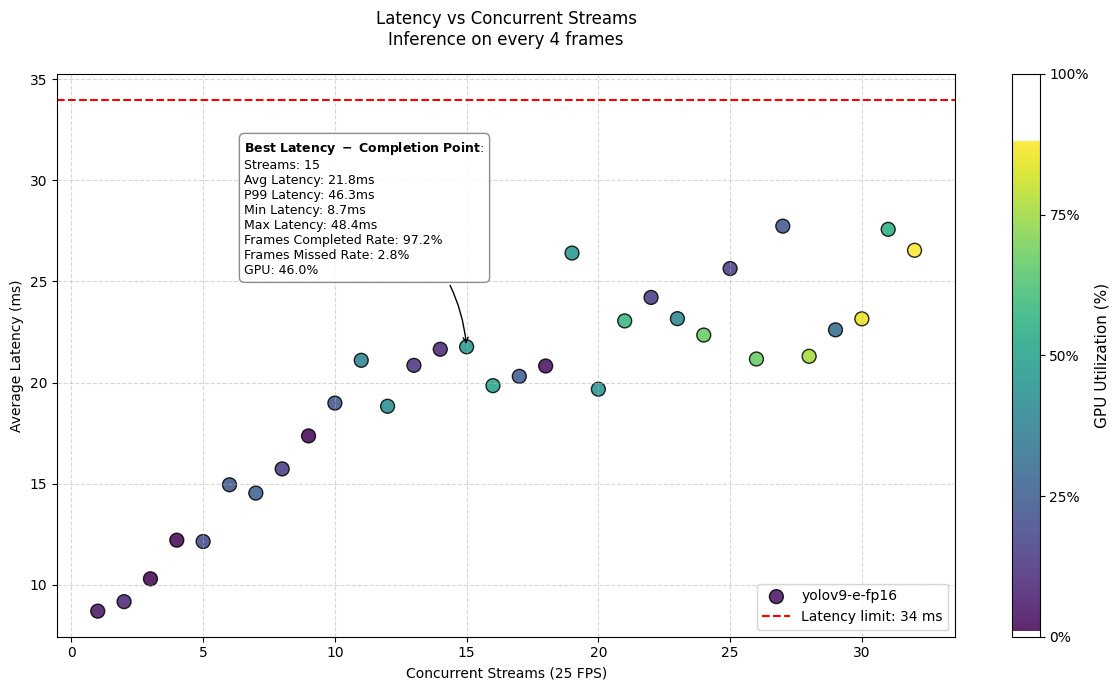

In [15]:
def plot_video_stream_latency(files, efficiency_threshold=90, latency_threshold_ms=50):
    for file_path in files:
        plt.figure(figsize=(12, 7))  # <-- now inside the loop (new plot per file)

        with open(file_path, "r") as f:
            results = json.load(f)

        x_streams = []
        y_latency = []
        gpu_utils = []
        frame_completion = []
        frame_miss = []
        p99s = []
        mins = []
        maxs = []

        for stream in sorted(results['streams_stats'], key=lambda x: x['num_streams']):
            stats = stream['overall_stats']
            x_streams.append(stream['num_streams'])
            y_latency.append(stats['avg_latency_ms'])
            gpu_utils.append(stats['gpu_util_percent'])
            frame_completion.append(stats['frame_completion_rate'])
            frame_miss.append(stats['missed_frame_rate'])
            p99s.append(stats['p99_latency_ms'])
            mins.append(stats['min_latency_ms'])
            maxs.append(stats['max_latency_ms'])

        norm_gpu_util = np.array(gpu_utils) / 100.0

        scatter = plt.scatter(
            x_streams, y_latency,
            c=norm_gpu_util,
            cmap='viridis',
            s=100,
            marker='o',
            edgecolor='k',
            label=results['model_name'],
            alpha=0.85
        )

        best_idx = None
        max_streams = -1

        for i, (streams, latency, frame_comp) in enumerate(zip(x_streams, y_latency, frame_completion)):
            if latency <= latency_threshold_ms and frame_comp >= efficiency_threshold and streams > max_streams:
                best_idx = i
                max_streams = streams

        if best_idx is None:
            for i, (streams, latency) in enumerate(zip(x_streams, y_latency)):
                if latency <= latency_threshold_ms and streams > max_streams:
                    best_idx = i
                    max_streams = streams

        if best_idx is not None:
            x = x_streams[best_idx]
            y = y_latency[best_idx]
            label_text = (
                r"$\bf{Best\ Latency\ -\ Completion\ Point}$:"
                f"\nStreams: {x}\n"
                f"Avg Latency: {y_latency[best_idx]:.1f}ms\n"
                f"P99 Latency: {p99s[best_idx]:.1f}ms\n"
                f"Min Latency: {mins[best_idx]:.1f}ms\n"
                f"Max Latency: {maxs[best_idx]:.1f}ms\n"
                f"Frames Completed Rate: {frame_completion[best_idx]:.1f}%\n"
                f"Frames Missed Rate: {frame_miss[best_idx]:.1f}%\n"
                f"GPU: {gpu_utils[best_idx]:.1f}%"
            )
            plt.annotate(
                label_text,
                (x, y),
                textcoords="offset points",
                xytext=(-160, 50),
                ha='left',
                va='bottom',
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.9),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.3")
            )

        plt.axhline(latency_threshold_ms, color='red', linestyle='--', label=f'Latency limit: {latency_threshold_ms} ms')

        plt.xlabel(f"Concurrent Streams ({results['fps_per_stream']} FPS)")
        plt.ylabel("Average Latency (ms)")
        plt.title(f"Latency vs Concurrent Streams\nInference on every {results['infer_every_n_frames']} frames\n", fontsize=12)

        cbar = plt.colorbar(scatter)
        cbar.set_label("GPU Utilization (%)", fontsize=11)
        cbar.ax.yaxis.set_tick_params(labelsize=10)
        cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
        cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

files = [
    "/home/yves/Desktop/real-time-object-detection/yolov9-e-fp16_video_stream_results.json",
]
plot_video_stream_latency(
    files,
    efficiency_threshold=97,
    latency_threshold_ms=34
)